In [1]:
import torch
import torch.nn.functional as F
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
from torch.utils.data import Dataset, DataLoader,random_split
import torch.optim as optim
from tqdm import tqdm
import h5py
import scipy
from scipy.signal import find_peaks
from IPython.display import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import optuna

import utils
import Model
import Simulate_Dataset

# Set a random seed for PyTorch
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
# dataset parameters
fs = 1000                     # sampling frequency in Hz
data_dur =  3*63                 # data duration in s
actpot_dur = 5                   # action potential length in ms
window_dur = 3                   # window dutation in s
C = 1                              # number of neurons
s = 80                              # number of appearance of each neuron in each window
x_mean = 2                         # code amplitude mean
x_std = 0.1                         # code amplitude std
noise_std = 0.1
snr = 20

K = int(actpot_dur * fs / 1000) # filter legnth
N = int(window_dur * fs)        # example duration
J = int(data_dur / window_dur)  # number of examples

# data parameters
data_hyp ={"J": J, "N": N, "K": K, "C": C, "s": s, "x_mean": x_mean,
           "x_std": x_std, "SNR": snr, "device": device}

print("filter length:", K)
print("example duration:", N)
print("number of examples:", J)

filter length: 5
example duration: 3000
number of examples: 63


In [3]:
# fill in the gaps
net_hyp = {"T": 200,                 # number of encoder unfolding
           "L": 10,                  # 1/L is the step size in the encoder
           "C": 1,                 # number of filters
           "K": 18,                  # legnth of the filters
           "lam": 0.2,
           "device": device
           }

net = Model.CRsAE1D(net_hyp)

# training parameters
train_hyp = {"batch_size": 8, "num_epochs": 12, "lr": 1e-2, "shuffle": True}
# criterion
criterion = torch.nn.MSELoss()
# optimizer
optimizer = optim.Adam(net.parameters(), lr=train_hyp["lr"], eps=1e-3)

In [4]:
snr_list = np.linspace(-10,50,13)
print(snr_list)

[-10.  -5.   0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.]


In [26]:
def f1_score(label, pred):
  label = np.array(label.cpu())
  true_positives = np.sum((pred == 1) & (label == 1))
  all_positives = np.sum(label == 1)
  predicted_positives = np.sum(pred == 1)

  precision = true_positives / predicted_positives if predicted_positives > 0 else 0.0
  recall = true_positives / all_positives if all_positives > 0 else 0.0

  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
  return f1_score

def check_naive_classifiers(signal, label,signal_name, k=10, optim_params = False):
    dataset_behave = create_behave_dataset_matrix(signal,label,device = device)
    X = dataset_behave.data.cpu()
    y = dataset_behave.label.cpu()

    kf = KFold(n_splits=k, shuffle=False)
    test_accuracy_list = []
    print("running tuna study on metric")
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if optim_params:
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
    
            def objective(trial):
                # Define hyperparameter search space
                model_type = trial.suggest_categorical('model', ['svm_linear', 'logistic'])
                C = trial.suggest_float('C', 0.01, 100, log=True)
    
                if model_type.startswith('svm'):
                    svm_classifier = svm.SVC(C=C, kernel='linear')
                    svm_classifier.fit(X_train, y_train)
                    y_val_pred = svm_classifier.predict(X_val)
                    val_accuracy = f1_score(y_val, y_val_pred)
                else:
                    logistic_classifier = LogisticRegression(C=C, max_iter=1000)
                    logistic_classifier.fit(X_train, y_train)
                    y_val_pred = logistic_classifier.predict(X_val)
                    val_accuracy = f1_score(y_val, y_val_pred)
    
                return val_accuracy
    
            # Create an Optuna study
            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=20)
    
            # Get the best trial
            best_trial = study.best_trial
            best_params = best_trial.params
            best_score = best_trial.value
            print("Best Hyperparameters from Optuna:", best_params)
            print("Best Validation Set Accuracy:", best_score)

            # Train the best model on the entire training set
            if best_params['model'].startswith('svm'):
                best_model = svm.SVC(C=best_params['C'], kernel=best_params['model'][4:])
            else:
                best_model = LogisticRegression(C=best_params['C'], max_iter=1000)
        else: 
            if signal_name == 'y':
                best_model = LogisticRegression(C=12.06, max_iter=1000)
            elif signal_name == 'y_hat':
                best_model = LogisticRegression(C=19.1, max_iter=1000)
            elif signal_name == 'x' or signal_name == 'x_hat':
                best_model = LogisticRegression(C=83.3, max_iter=1000)
            else:
                best_model = svm.SVC(C=1, kernel='linear')
            
        best_model.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_test_pred = best_model.predict(X_test)
        test_accuracy = f1_score(y_test, y_test_pred)

        
        print("Test Set Accuracy:", test_accuracy)
        test_accuracy_list.append(test_accuracy)
    plt.figure()
    # Create subplots
    plt.subplot(3, 1, 1)
    plt.plot(y_test.T, label='ground truth')
    plt.subplot(3, 1, 2)
    plt.plot(y_test_pred.T, label='predicted')
    plt.subplot(3, 1, 3)
    plt.plot(X_test.mT[0], label='signal')
    # Show or save the figure
    plt.tight_layout()  # Adjust subplot spacing for clarity
    plt.show()

    return np.mean(test_accuracy_list)


class create_behave_dataset_matrix(Dataset):
    def __init__(self, x,label,device):
        self.label = label
        chunks = torch.split(x, 1, dim=1)
        # Concatenating the chunks along the first dimension
        self.data = x.T

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return  self.data[idx], self.label[idx]

In [27]:
snr_list = [(10,0.15),(15,0.15),(20,0.1),(25,0.05),(30,0.05),(35,0.1),(40,0),(45,0),(50,0),(-10,0.9),(-5,0.5),(0,0.3),(5,0.25)]
#snr_list = [(5,0.25)]

In [28]:
x_f1_score = []
y_f1_score = []
y_hat_f1_score = []
cur_snr_list = []
x_const = None

In [43]:
for itr in range(1):
  print(f"%%%%%%%%%%%%%%{itr}%%%%%%%%%%%%%%%%%")
  for cur_snr, cur_lam in snr_list:
    net_hyp = {"T": 200,                 # number of encoder unfolding
            "L": 10,                  # 1/L is the step size in the encoder
            "C": 2,                 # number of filters
            "K": 18,                  # legnth of the filters
            "lam": cur_lam,
            "device": device
            }
    data_hyp ={"J": J, "N": N, "K": K, "C": C, "s": s, "x_mean": x_mean,
            "x_std": x_std, "SNR": cur_snr, "device": device}
    dataset = Simulate_Dataset.SimulatedDataset1D(data_hyp,x_const,one_kernel = True)
    net = Model.CRsAE1D(net_hyp)
    net.load_state_dict(torch.load(f'pretrained_on_simulated_data\snr_{snr_list[0][0]}.pth'))
    with torch.no_grad():
      y,x,_,_ = dataset[:]
      x_const = x
      x = torch.sum(x, dim=1, keepdim=True)
      y_hat, x_hat = net(y)
      #utils.vis_data_est(y[1,0], y_hat[1,0])
      x_hat = torch.sum(x_hat, dim=1, keepdim=True)
      y = y.squeeze(dim = 1)
      b = x[0,0] > 0
      x = x.squeeze(dim = 1)
      y_hat = y_hat.squeeze(dim = 1)
      x_hat = x_hat.squeeze(dim = 1)
      padding_begining = 15
      padding_end = 19
      # Perform the padding
      padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
      modified_tensor = torch.zeros_like(padded_tensor).to(device)
      indices_of_ones = torch.nonzero(padded_tensor).squeeze()
      for index in indices_of_ones:
        modified_tensor[index-1:index+3] = 1

    x_f1_score = []
    y_f1_score = []
    y_hat_f1_score = []
    x_hat_f1_score = []
    print(f"For SNR = {cur_snr}")
    print("On x")
    x_f1_score.append(check_naive_classifiers(x, b,'x'))
    print("On y")
    y_f1_score.append(check_naive_classifiers(y, modified_tensor,'y'))
    print("On y_hat")
    y_hat_f1_score.append(check_naive_classifiers(y_hat, modified_tensor,'y_hat'))
    #print("on x_hat")
    #x_hat_f1_score.append(check_naive_classifiers(x_hat, modified_tensor,'x_hat',optim_params = True))
    cur_snr_list.append(cur_snr)

  # reset x for new study
  x_const = None

%%%%%%%%%%%%%%0%%%%%%%%%%%%%%%%%


C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_10472\1039872477.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
For SNR = 10
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
For SNR = 15
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
For SNR = 20
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
For SNR = 25
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
For SNR = 30
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
For SNR = 35
tensor([0.0040, 0.0028, 0.0047,  ..., 0.0046, 0.0000, 0.0005], device='cuda:0')
For SNR = 40
tensor([0.0026, 0.0014, 0.0012,  ..., 0.0014, 0.0032, 0.0000], device='cuda:0')
For SNR = 45
tensor([0.0000, 0.0017, 0.0000,  ..., 0.0005, 0.0013, 0.0005], device='cuda:0')
For SNR = 50
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
For SNR = -10
tensor([0.1133, 0.0000, 0.0882,  ..., 1.6051, 0.0000, 0.5055], device='cuda:0')
For SNR = -5
tensor([0.0000, 0.0000, 0.0523,  ..., 0.0332, 0.0000, 0.0000], device='cuda:0')
For SNR = 0
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:

3030
3030


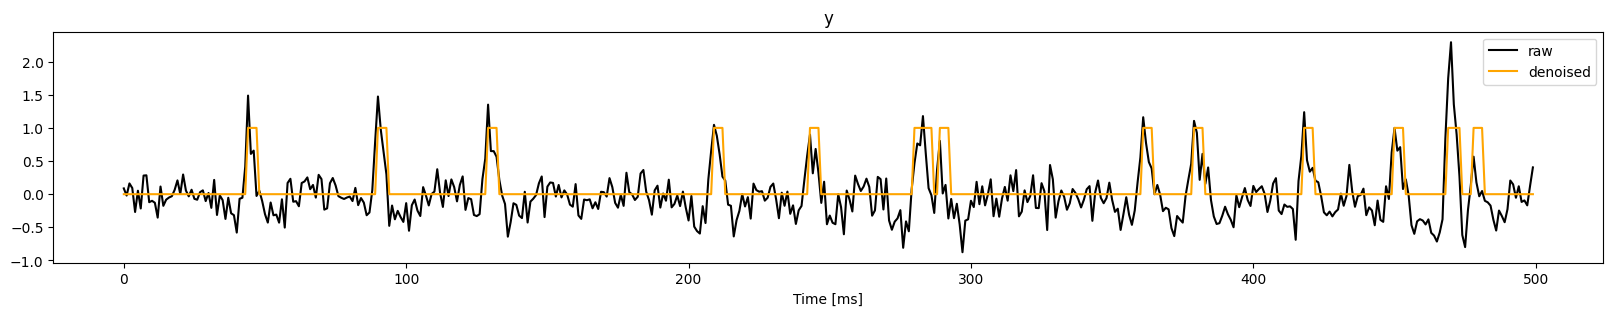

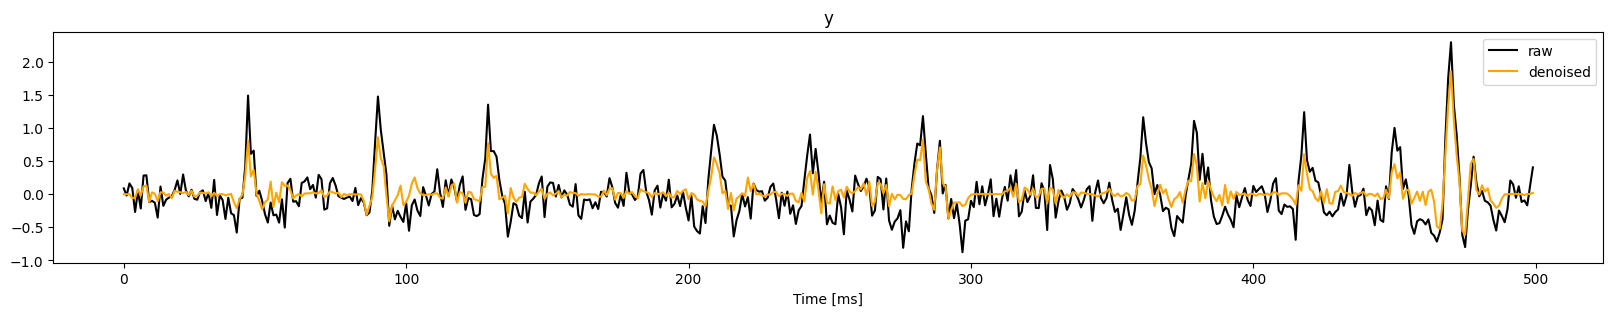

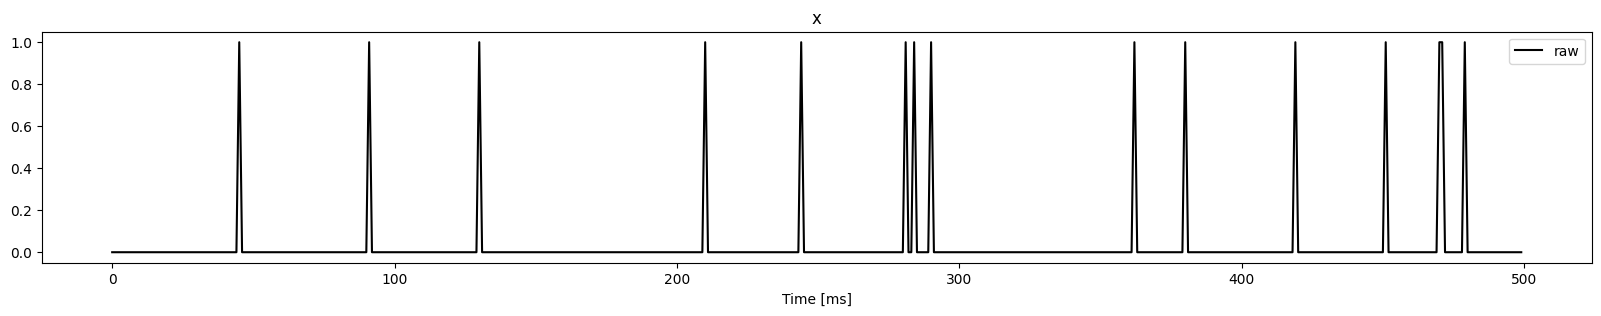

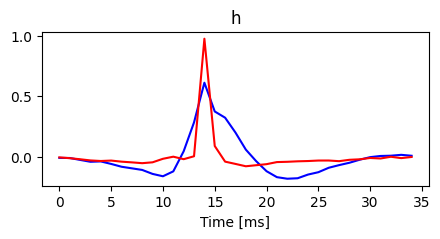

In [20]:
yi,xi,h,_ = dataset[0:3]
yi_hat, xi_hat = net(yi)

utils.vis_data_est(yi[0,0][0:500], modified_tensor[0:500])
utils.vis_data_est(yi[0,0][0:500], yi_hat[0,0][0:500])


print(len(padded_tensor))
print(len(yi[0,0]))
utils.vis_data(padded_tensor[0:500])
#utils.vis_data(b)
utils.vis_filters(h)

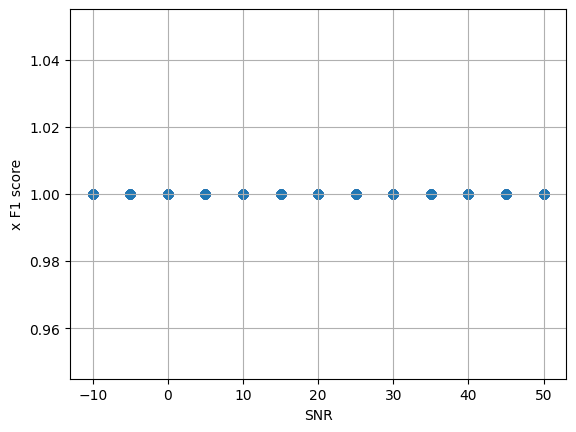

In [21]:
plt.scatter(cur_snr_list,x_f1_score, marker='o')
plt.xlabel('SNR')
plt.ylabel('x F1 score')
plt.title('')
plt.grid(True)
plt.show()

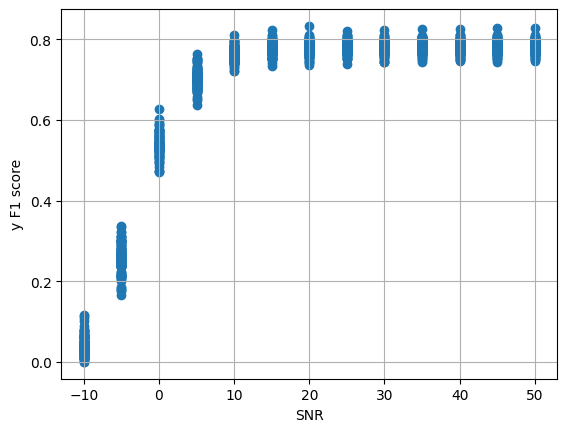

In [22]:
plt.scatter(cur_snr_list,y_f1_score, marker='o')
plt.xlabel('SNR')
plt.ylabel('y F1 score')
plt.title('')
plt.grid(True)
plt.show()

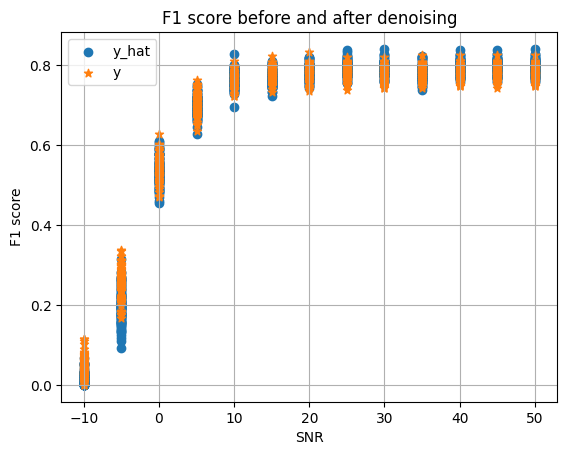

In [23]:
plt.scatter(cur_snr_list, y_hat_f1_score, marker='o')
plt.scatter(cur_snr_list,y_f1_score, marker='*')
plt.xlabel('SNR')
plt.ylabel('F1 score')
plt.legend(['y_hat','y'])
plt.title('F1 score before and after denoising')
plt.grid(True)
plt.show()

In [24]:
import pandas as pd
data = {'SNR': cur_snr_list, 'F1 score y_hat': y_hat_f1_score, 'F1 score y': y_f1_score}
df = pd.DataFrame(data)

# Specify the file name
csv_filename = 'results\simulated_behave_data_comperison_dialated_new_kernel2.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_filename, index=False)

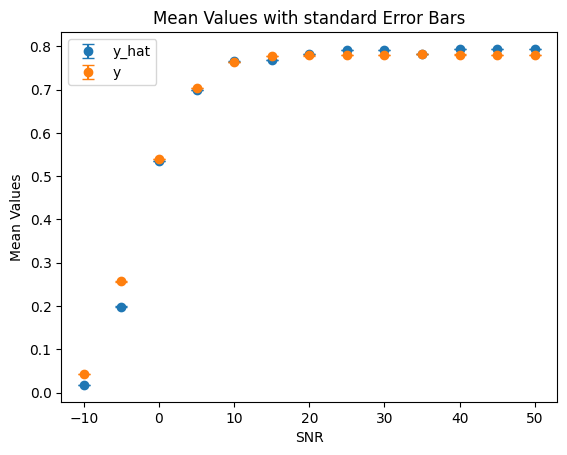

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.pandas.read_csv('results\simulated_behave_data_comperison_dialated_new_kernel2.csv')

# Group the data by SNR and calculate mean and variance
grouped = df.groupby('SNR').agg({'F1 score y_hat': ['mean', 'std','count']})

# Extract the mean and variance values
means = grouped['F1 score y_hat']['mean']
std = grouped['F1 score y_hat']['std']
standard_error = std/grouped['F1 score y_hat']['count']

# Create a bar plot with error bars
plt.errorbar(means.index, means, yerr=standard_error, fmt='o', capsize=4)
# Group the data by SNR and calculate mean and variance
grouped = df.groupby('SNR').agg({'F1 score y': ['mean', 'std','count']})

# Extract the mean and variance values
means = grouped['F1 score y']['mean']
std = grouped['F1 score y']['std']
standard_error = std/grouped['F1 score y']['count']

# Create a bar plot with error bars
plt.errorbar(means.index, means, yerr=standard_error, fmt='o', capsize=4)

# Add labels and title
plt.xlabel('SNR')
plt.ylabel('Mean Values')
plt.title('Mean Values with standard Error Bars')
plt.legend(['y_hat','y'])

# Show the plot
plt.show()